# CptS 481 - Python Software Construction

## Unit 16: Distributing

In [1]:
from IPython.display import HTML
HTML(open("../include/notes.css", "r").read())

In [2]:
# make sure the demos and applications directories exist
! [ -d demos ] || mkdir demos

In [12]:
# This allows us to import "dot" graph visualization files (recommended)
import graphviz
import os

def fig(fname, *args, **kwds):
    dotSource = open(os.path.join("figures", fname)).read()
    return graphviz.Source(dotSource, *args, **kwds)

# You also need to have the "graphviz" executables installed on your system.
# On Ubuntu, this shell command will install them:
# $ sudo apt install graphviz

How do you go about sharing Python code with the rest of the world? Desirable features:

* There should be a single package you can email or put in a repository somewhere.

* It should install and run anywhere there's a Python (3K) interpreter and possibly nothing else (e.g. ``make``, ``cmake``, ``apt-get`` etc.).

* It should install to standard places where anybody can run (a script) or ``import`` (a module or package) it.

* There should be a way to create "binary" installation packages for a variety of platforms.

* It should be easy to submit your work to a shared repository.

The ``setuptools`` package was designed to permit these.

### Distributing a Single Module

Suppose you have a Python module ``hello.py`` that you want to distribute:

In [9]:
! [ -d demos/d0_hello ] || mkdir demos/d0_hello

In [10]:
%%file demos/d0_hello/hello.py
print("Hello, world!")

Overwriting demos/d0_hello/hello.py


For clarity, we put ``hello.py`` in an otherwise empty directory ``d0_hello``. This name is arbitrary and is not used anywhere in the distribution process. This could in fact be the source code directory for your project.

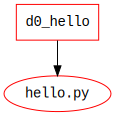

In [13]:
fig("g00_module.gv")

In these diagrams, we'll use squares for directories and ellipses for files and red to indicate additions to the previous graph.

Aside: In this notebook, we're displaying graphs using the "graphviz" graph visualization format. It's pretty handy. Here's what produced the diagram above:

In [ ]:
# %load figures/g00_module.gv
digraph setuptools {
    node [ fontname="courier" ];
    d0_hello -> hello_py;
    d0_hello [ label="d0_hello", shape=box, color="red"];
    hello_py [ label="hello.py", color="red" ];
}

RESUME ON 11/10

#### The ``setup.py`` File

You then create a new file ``setup.py`` in the same directory:

In [27]:
%%file demos/d0_hello/setup.py
from setuptools import setup

setup(name='hello', # the package/module name
      version='1.0', # the version (an arbitrary string)
      author='Bob Lewis', # someone to blame
      author_email='bobl@wsu.edu', # where to flame
      py_modules=[ 'hello' ], # modules in the package 
      )

Writing demos/d0_hello/setup.py


so the directory now looks like this:

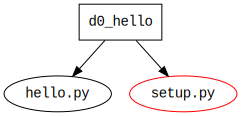

In [28]:
fig("g01_module_setup.gv")

All of the arguments to ``setup()`` are keyworded, and there are a lot of them. Most of them can be ignored. ``setup.py`` is the key to getting ``setuptools`` to work. You always invoke it as a Python module from the source ("``d0_hello``" here) directory.

The ``setup()`` invocation in ``setup.py`` does most of the work. What it actually does is determined by the command line (see below), which it accesses through ``sys.argv``. Think of its role like that of a makefile. It even does timestamp dependency analyses.

``setuptools`` provides extensive help:

In [29]:
!cd demos/d0_hello; python3 setup.py --help

Common commands: (see '--help-commands' for more)

  setup.py build      will build the package underneath 'build/'
  setup.py install    will install the package

Global options:
  --verbose (-v)      run verbosely (default)
  --quiet (-q)        run quietly (turns verbosity off)
  --dry-run (-n)      don't actually do anything
  --help (-h)         show detailed help message
  --no-user-cfg       ignore pydistutils.cfg in your home directory
  --command-packages  list of packages that provide distutils commands

Information display options (just display information, ignore any commands)
  --help-commands     list all available commands
  --name              print package name
  --version (-V)      print package version
  --fullname          print <package name>-<version>
  --author            print the author's name
  --author-email      print the author's email address
  --maintainer        print the maintainer's name
  --maintainer-email  print the maintainer's email address
  --co

and specific commands are listed like this:

In [30]:
!cd demos/d0_hello; python3 setup.py --help-commands

Standard commands:
  build             build everything needed to install
  build_py          "build" pure Python modules (copy to build directory)
  build_ext         build C/C++ extensions (compile/link to build directory)
  build_clib        build C/C++ libraries used by Python extensions
  build_scripts     "build" scripts (copy and fixup #! line)
  clean             clean up temporary files from 'build' command
  install           install everything from build directory
  install_lib       install all Python modules (extensions and pure Python)
  install_headers   install C/C++ header files
  install_scripts   install scripts (Python or otherwise)
  install_data      install data files
  sdist             create a source distribution (tarball, zip file, etc.)
  register          register the distribution with the Python package index
  bdist             create a built (binary) distribution
  bdist_dumb        create a "dumb" built distribution
  bdist_rpm         create an RPM dis

Two things to note:

* You'll see the package ``distutils`` referred to in the help documentation for ``setuptools``. ``setuptools`` is an enhanced version of the former packaging utility ``distutils`` and is referred to for backwards compatibility. (In fact, you can still use the ``distutils`` package if you like for much of what we present here.)

* There are references to "eggs". An ``.egg`` file is a "logical structure embodying the release of a specific version of a Python project, comprising its code, resources, and metadata". They are typically ``zip``-compressed and may be accessed from Python via the ``import`` statement just like a ``*.py`` file, a directory containing a ``__init__.py`` file, a ``*.so`` file, etc. We'll explore their contents below.

#### The ``build`` Process

The first step to distributing a Python package is the "build" step. You do it by ``cd``ing to that directory and invoking ``setup.py`` with the build argument:

In [31]:
# this command avoids setuptool's optimization for demo purposes
!cd demos/d0_hello; touch hello.py

!cd demos/d0_hello; python3 setup.py build

running build
running build_py
creating build
creating build/lib
copying hello.py -> build/lib


The "running" messages are just informative: Any real actions taken are explicit (like the copy).

This will create the following:

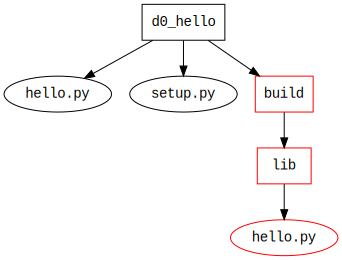

In [22]:
fig("g02_after_module_build.gv")

All ``setuptools`` has had to do here as part of the build is copy the file. It's actually capable of doing much more (e.g. compiling C extensions -- in an upcoming unit), but that's all it needs to do here. The ``build`` subdirectory is a temporary holding area and can be deleted when no longer used.

If you're using `git` or `subversion`, you can ignore `build` entirely.

#### The ``install`` Process

Once the ``build`` directory is set up, the next step is to install the package. To be on the safe side, I recommend using the ``--dry-run`` option, which tells ``setuptools`` to show what it's going to do, not actually do:

In [23]:
# This will fail due to permissions:
!cd demos/d0_hello; python3 setup.py install --dry-run

running install
running bdist_egg
running egg_info
writing hello.egg-info/PKG-INFO
writing dependency_links to hello.egg-info/dependency_links.txt
writing top-level names to hello.egg-info/top_level.txt
reading manifest file 'hello.egg-info/SOURCES.txt'
writing manifest file 'hello.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying hello.py -> build/lib
creating build/bdist.linux-x86_64/egg
copying build/lib/hello.py -> build/bdist.linux-x86_64/egg
byte-compiling build/bdist.linux-x86_64/egg/hello.py to hello.cpython-38.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/top_level.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
zip_safe flag not set; analyzing archiv

As you can see, the install failed because we don't have install permission in the system-wide directory ``/usr/local/lib/python3.8/dist-packages``. That means that to install there, we'd have to do so as ``root`` (possibly running the ``python3`` command via ``sudo``).

But there's an alternative if you're working on a system you can't run as ``root`` on:
The ``--user`` flag puts the module in a directory under your home directory:

In [24]:
!cd demos/d0_hello; python3 setup.py install --user

running install
running bdist_egg
running egg_info
writing hello.egg-info/PKG-INFO
writing dependency_links to hello.egg-info/dependency_links.txt
writing top-level names to hello.egg-info/top_level.txt
reading manifest file 'hello.egg-info/SOURCES.txt'
writing manifest file 'hello.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
copying build/lib/hello.py -> build/bdist.linux-x86_64/egg
byte-compiling build/bdist.linux-x86_64/egg/hello.py to hello.cpython-38.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying hello.egg-info/top_level.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
zip_safe flag not set; analyzing archive contents...
creating 'dist/h

This installs all the files in directories below your home directory where you presumably have write access, including a ``site-packages`` directory that your ``import`` statements will automatically access, as seen below:

In [25]:
from pprint import pprint
import sys
pprint(sys.path)

['/home/bobl/Dropbox/cpts481/u16_distributing',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/bobl/.local/lib/python3.8/site-packages',
 '/home/bobl/.local/lib/python3.8/site-packages/vase_projection-1.3-py3.8.egg',
 '/home/bobl/.local/lib/python3.8/site-packages/curriculorum-1.3.0-py3.8.egg',
 '/home/bobl/.local/lib/python3.8/site-packages/argparse-1.4.0-py3.8.egg',
 '/home/bobl/.local/lib/python3.8/site-packages/pyrayt-2.2.0-py3.8.egg',
 '/home/bobl/.local/lib/python3.8/site-packages/hello-1.0-py3.8.egg',
 '/home/bobl/.local/lib/python3.8/site-packages/ancient_math-1.0-py3.8.egg',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/hello-1.0-py3.8.egg',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/bobl/.ipython']


This is also how your friend can install a package you send them without having sysadmin privileges, either.

Assuming we **do** have root access, the installation will do this:

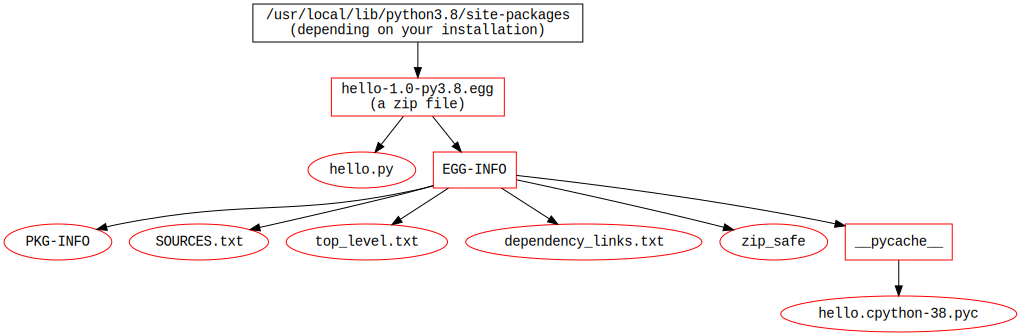

In [26]:
fig("g03_after_module_install.gv")

The "``EGG-INFO/PKG-INFO``" file in the zip archive contains metainformation about the release. (we'll use the one installed in our user directory.)

In [27]:
!unzip -ca /home/bobl/.local/lib/python3.8/site-packages/hello-1.0-py3.8.egg EGG-INFO/PKG-INFO

Archive:  /home/bobl/.local/lib/python3.8/site-packages/hello-1.0-py3.8.egg
  inflating: EGG-INFO/PKG-INFO       [binary]
Metadata-Version: 1.0
Name: hello
Version: 1.0
Summary: UNKNOWN
Home-page: UNKNOWN
Author: Bob Lewis
Author-email: bobl@wsu.edu
License: UNKNOWN
Description: UNKNOWN
Platform: UNKNOWN



This allows other installations to verify that your version is compatible with theirs. The "``UNKNOWN``"s are fields that we can fill in with arguments to ``setup()``.

Incidentally, if you forget to ``build``, ``install`` will do it for you. The only problem with that is that if you need to install as root (using ``sudo``), the build files in your directory will be owned by ``root`` and you'll have to remove them as ``root`` (again probably using ``sudo``).

In short, when you install for the system (i.e. under ``/usr/local``), ``build`` as you and ``install`` as root.

#### Sending the Source Somewhere

So we can build and install on our own system, but now we want to send the code somewhere else: a "source distribution". To do this, we again use ``setup.py``:

In [51]:
!cd demos/d0_hello; python3 setup.py sdist

running sdist
running egg_info
writing hello.egg-info/PKG-INFO
writing dependency_links to hello.egg-info/dependency_links.txt
writing top-level names to hello.egg-info/top_level.txt
reading manifest file 'hello.egg-info/SOURCES.txt'
writing manifest file 'hello.egg-info/SOURCES.txt'

running check

creating hello-1.0
creating hello-1.0/hello.egg-info
copying files to hello-1.0...
copying hello.py -> hello-1.0
copying setup.py -> hello-1.0
copying hello.egg-info/PKG-INFO -> hello-1.0/hello.egg-info
copying hello.egg-info/SOURCES.txt -> hello-1.0/hello.egg-info
copying hello.egg-info/dependency_links.txt -> hello-1.0/hello.egg-info
copying hello.egg-info/top_level.txt -> hello-1.0/hello.egg-info
Writing hello-1.0/setup.cfg
Creating tar archive
removing 'hello-1.0' (and everything under it)


In order, the warnings tell us:

* We should provide a "url=" argument to ``setup()`` to refer to a Web site (e.g. PyPI).

* We can add a "``MANIFEST.in``" file in ``hello`` to list additional files (e.g. stand-alone documentation) to include in the distribution and also files to exclude.

* We should add a "``README``", "``README.txt``", or "``README.rst``" file in the distibution.

Note the comment:

* Remember: ``distutils`` is the predecessor of ``setuptools`` and is a subset. Don't worry if you see it in ``setuptools`` output.

* If we had files listed in ``MANIFEST.in``, their names would be in ``MANIFEST`` as well.

Here's the directory hierarchy now:

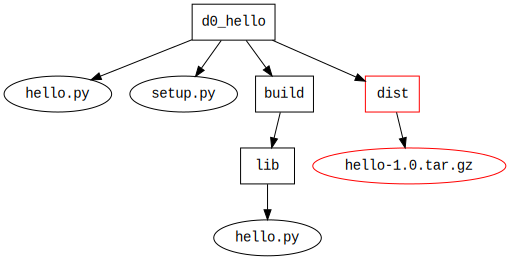

In [55]:
fig("g04_after_module_sdist.gv")

And the contents of "``hello-1.0.tar.gz``", which is just a gzipped tarball we all know and love.

In [57]:
!cd demos/d0_hello; tar -tzf dist/hello-1.0.tar.gz

hello-1.0/
hello-1.0/PKG-INFO
hello-1.0/hello.egg-info/
hello-1.0/hello.egg-info/PKG-INFO
hello-1.0/hello.egg-info/SOURCES.txt
hello-1.0/hello.egg-info/dependency_links.txt
hello-1.0/hello.egg-info/top_level.txt
hello-1.0/hello.py
hello-1.0/setup.cfg
hello-1.0/setup.py


The tarball includes the same ``setup.py`` we've been using all along, so anyone who gets the tarball and has ``setuptools`` installed can do anything we do in this demo, including create another source distribution. This is embodiment of open source.

The ``PKG-INFO`` file is the same as was included in the ``EGG-INFO`` directory within the ``*.egg`` zipfile we looked at above.

#### ``Binary`` Distributions

A "binary" distribution is a bit of a misnomer: It includes the source, but it's designed to be used, not modified. In addition, it also installs in a single step, depending on the platform, and compiles Python files to bytecodes. (These, at least, are the defaults.)

There are four kinds of binary distribution, selected by the ``setup.py`` argument:

* ``bdist_dumb``

  A tarball designed to be un-``tar``red in the right place.

* ``bdist_rpm``

  A file in with the Red Hat Package Manager format.

* ``bdist_wininst``

  An "``.exe``" file that installs the module or package when run on a Windows platform. (This ``setuptools`` command only works on a Windows machine.)
  
* ``bdist_wheel``

  This is the new standard in use by ``PyPI`` (the Python Package Index) that is intended to replace "eggs"s.

If you don't specify any of these, it chooses a platform specific one: ``bdist_dumb`` on Linux (and maybe Mac) machines and ``bdist_wininst`` on Windows machines.

You'll notice that there's no way to build a Debian ("``*.deb``") package here. Actually, you can with some ``setuptools`` extensions, but its better to use ``pip3``, which accesses ``PyPI`` (see below) than a distribution-specific package manager like ``apt-get`` or ``yum``.

In [58]:
!cd demos/d0_hello; python3 setup.py bdist

running bdist
running bdist_dumb
running build
running build_py
installing to build/bdist.linux-x86_64/dumb
running install
running install_lib
creating build/bdist.linux-x86_64/dumb
creating build/bdist.linux-x86_64/dumb/usr
creating build/bdist.linux-x86_64/dumb/usr/local
creating build/bdist.linux-x86_64/dumb/usr/local/lib
creating build/bdist.linux-x86_64/dumb/usr/local/lib/python3.8
creating build/bdist.linux-x86_64/dumb/usr/local/lib/python3.8/dist-packages
copying build/lib/hello.py -> build/bdist.linux-x86_64/dumb/usr/local/lib/python3.8/dist-packages
byte-compiling build/bdist.linux-x86_64/dumb/usr/local/lib/python3.8/dist-packages/hello.py to hello.cpython-38.pyc
running install_egg_info
running egg_info
writing hello.egg-info/PKG-INFO
writing dependency_links to hello.egg-info/dependency_links.txt
writing top-level names to hello.egg-info/top_level.txt
reading manifest file 'hello.egg-info/SOURCES.txt'
writing manifest file 'hello.egg-info/SOURCES.txt'
Copying hello.egg-info

Notice what's going on: ``setuptools`` is building a sparse directory hierarchy resembling the *whole* filesystem below ``build/bdist.{platform}/dumb/``, byte compiling the Python source into it, and tarring everything up.

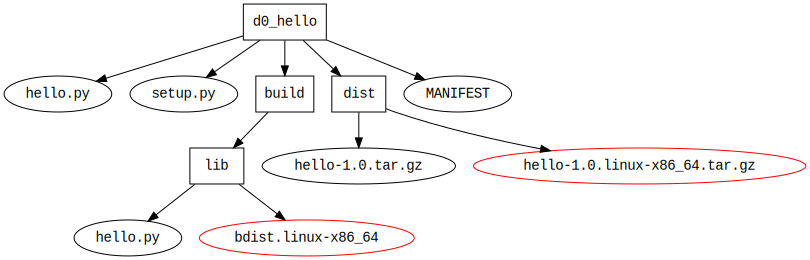

In [59]:
fig("g05_after_module_bdist.gv")

Here's what the tarball contains:

In [60]:
!tar -tzf demos/d0_hello/dist/hello-1.0.linux-x86_64.tar.gz

./
./usr/
./usr/local/
./usr/local/lib/
./usr/local/lib/python3.8/
./usr/local/lib/python3.8/dist-packages/
./usr/local/lib/python3.8/dist-packages/__pycache__/
./usr/local/lib/python3.8/dist-packages/__pycache__/hello.cpython-38.pyc
./usr/local/lib/python3.8/dist-packages/hello-1.0.egg-info/
./usr/local/lib/python3.8/dist-packages/hello-1.0.egg-info/PKG-INFO
./usr/local/lib/python3.8/dist-packages/hello-1.0.egg-info/SOURCES.txt
./usr/local/lib/python3.8/dist-packages/hello-1.0.egg-info/dependency_links.txt
./usr/local/lib/python3.8/dist-packages/hello-1.0.egg-info/top_level.txt
./usr/local/lib/python3.8/dist-packages/hello.py


If you "``cd /``" and un-``tar`` the file there (or pass "``-C /``" to ``tar``), all the files (and, if needed, directories) will end up in the same places they would for "``$ python3 setup.py install``".

### Distributing a Package

Most Python code worth distributing comes in a package: a directory containing multiple Python source files. Here's the initial layout:

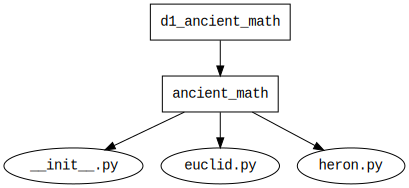

In [61]:
fig("g06_package.gv")

Review: What makes this a package?

We add a ``setup.py`` that is slightly different from before:

In [64]:
%%file demos/d1_ancient_math/setup.py
from setuptools import setup

setup(name='ancient_math',
      version='1.0',
      author='Bob Lewis',
      author_email='bobl@wsu.edu',
      packages=['ancient_math'], # name change and "packages", not "py_modules"
      )

Overwriting demos/d1_ancient_math/setup.py


In [65]:
!cd demos/d1_ancient_math; python3 setup.py build

running build
running build_py


``setuptools`` copies all of the files in ``ancient_math`` to ``build/lib``.

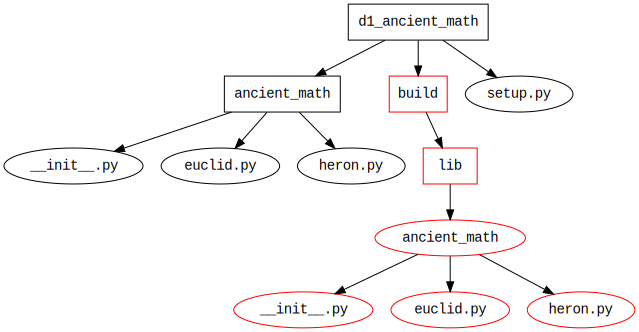

In [68]:
fig("g07_after_package_build.gv")

And everything else is much the same as for a module.

In [6]:
!cd demos/d1_ancient_math; python3 setup.py install --user

running install
running bdist_egg
running egg_info
writing ancient_math.egg-info/PKG-INFO
writing dependency_links to ancient_math.egg-info/dependency_links.txt
writing top-level names to ancient_math.egg-info/top_level.txt
reading manifest file 'ancient_math.egg-info/SOURCES.txt'
writing manifest file 'ancient_math.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ancient_math
copying build/lib/ancient_math/heron.py -> build/bdist.linux-x86_64/egg/ancient_math
copying build/lib/ancient_math/__init__.py -> build/bdist.linux-x86_64/egg/ancient_math
copying build/lib/ancient_math/euclid.py -> build/bdist.linux-x86_64/egg/ancient_math
byte-compiling build/bdist.linux-x86_64/egg/ancient_math/heron.py to heron.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/ancient_math/__init__.py to __init__.cpython-38.pyc
byte-compiling build/bdist.linux-

**You need to restart the Jupyter kernel at this point to get the "import" to work after the install.**

In [8]:
import ancient_math as am
am.euclid(234, 23400)

234

In [9]:
am.triangleArea(23, 19, 30)

218.4856974723975

### Uninstalling Packages

Once you've installed a package, you can remove it using the ``pip`` (or ``pip3``) command:

In [10]:
# The "-y" flag avoids the confirmation query that confuses Jupyter.
!python3 -m pip uninstall -y ancient_math

Found existing installation: ancient-math 1.0
Uninstalling ancient-math-1.0:
  Successfully uninstalled ancient-math-1.0


**You need to restart the Jupyter kernel at this point to get the "import" to not work after the install.**

In [4]:
import ancient_math

### PyPI: The Python Package Index

The Python Package Index (http://pypi.python.org) is a central repository for Python packages. Currently, it contains over 150,000 packages, all installable via the ``pip`` module:

>    ``python3 -m pip install {package_name}``

On many systems, thie command does the same thing:

>    ``pip3 install {package_name}``

``pip`` is PyPI's equivalent to ``apt-get``, ``yum``, ``rpm``, and ``homebrew``.

``setuptools`` has a built-in connection to PyPI:

>    ``$ python3 setup.py register``

will register the distribution with PyPI.

>    ``$ python3 setup.py upload``

will upload the latest distribution to PyPI.